**<u>ПЛАН РАБОТЫ</u>**
1. Загрузка и предобработка данных<br>
    1.1. загрузка данных<br>
    1.2. предобработка данных<br>
    1.3. объединение данных<br>
    1.4. исследовательский анализ данных<br>
2. Модели ML<br>
    2.1. разделение данных на обучающую и тестовую выборки<br>
    2.2. подготовка данных для ML модели RandomForest<br>
    2.3. подготовка данных для ML моделей LogisticRegression и CatBooost<br>
    2.4. обучение моделей<br>
3. Тестирование модели и анализ результатов<br>
    3.1. тестирование и проверка на адекватность<br>
    3.2. вычисление важности признаков<br>
    3.3. матрица ошибок<br>
4. Общий выврод и рекомендации заказчику<br>

In [1]:
#!pip install -q phik
#!pip install -U scikit-learn

In [2]:
# импорт библиотек

import os
import re
import time
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

import phik

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score 
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyClassifier 

RANDOM_STATE=61125

# финализация: убираем предупреждения Pandas Future warning 
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# import pandas

In [3]:
# функции для визуализации распредедения данных

def bar_plot_data(df, column):
    df = df.copy()
    
    col_data = df[column]
    if pd.api.types.is_integer_dtype(col_data) and col_data.nunique() <= 2:
        df[column] = df[column].astype('category')
    
    counts = df[column].value_counts()
    plot_df = counts.reset_index()
    plot_df.columns = [column, 'count']
    
    norm = plt.Normalize(plot_df['count'].min(), plot_df['count'].max())
    colors = plt.cm.Greens(norm(plot_df['count']))
    
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=plot_df, 
        y=column, 
        x='count', 
        palette=colors, 
        edgecolor='darkgreen', 
        linewidth=1.5
    )
    
    plt.title(f"Распределение по признаку {column}\n", fontsize=16)
    plt.xlabel('Количество', fontsize=14)
    plt.ylabel(column, fontsize=14)
    plt.tight_layout()
    plt.show()

def data_box_hist(x):
    f, (ax_box, ax_hist) = plt.subplots(
                                2, 
                                sharex=True,
                                #figsize=(10, 6),
                                gridspec_kw={"height_ratios": (.15, .85)}
                                )

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=12, kde=True, ax=ax_hist)

    ax_box.set(yticks=[])
    ax_hist.set_ylabel('Количество')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    return plt.show()

# функции для визуализации оттока
# для численных признаков
def outflow_hist(column, bins):
    ax = sns.histplot(
        data=df,
        x=column,
        hue='target',
        stat='density',
        common_norm=False,
        bins=bins,
        hue_order=df['target'].unique() 
    )

    plt.title('Отток vs Наши клиенты')
    plt.xlabel(column)
    plt.ylabel('Плотность')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(['Отток', 'Наши клиенты'])

    plt.show()
    
# для категориальных признаков
def outflow_cat(df, column):
    average_target = df['target'].mean()
    
    col_data = df[column]
    if pd.api.types.is_integer_dtype(col_data) and col_data.nunique() <= 2:
        df = df.copy()
        df[column] = df[column].astype('category')
    
    plot_df = df.groupby(column, as_index=False)['target'].mean().sort_values('target')
    
    norm = plt.Normalize(plot_df['target'].min(), plot_df['target'].max())
    colors = plt.cm.Reds(norm(plot_df['target']))
    
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=plot_df,
        y=column,
        x='target',
        palette=colors,
        edgecolor='darkred',
        linewidth=1.5
    )
    
    plt.axvline(average_target, color='red', linestyle='--', label='Средний уровень оттока')
    
    plt.title(f'Уровень оттока по категориям признака {column} \n', fontsize=14)
    plt.xlabel('Средний уровень оттока', fontsize=12)
    plt.ylabel(column, fontsize=12)
    
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=1,
        frameon=False 
    )
    
    plt.tight_layout()
    plt.show()

## Загрузка и предобработка данных
### загрузка данных

In [4]:
local_paths = {
    'contract_new': r'D:\docs\DS\contract_new.csv',
    'personal_new': r'D:\docs\DS\personal_new.csv',
    'internet_new': r'D:\docs\DS\internet_new.csv',
    'phone_new': r'D:\docs\DS\phone_new.csv'
}

urls = {
    'contract_new': 'https://code.s3.yandex.net/datasets/contract_new.csv',
    'personal_new': 'https://code.s3.yandex.net/datasets/personal_new.csv',
    'internet_new': 'https://code.s3.yandex.net/datasets/internet_new.csv',
    'phone_new': 'https://code.s3.yandex.net/datasets/phone_new.csv'
}

data = {}

for name in local_paths:
    if os.path.exists(local_paths[name]):
        data[name] = pd.read_csv(local_paths[name])
        print(f'{name} загружен из локального файла.')
    else:
        response = requests.get(urls[name])
        if response.status_code == 200:
            data[name] = pd.read_csv(urls[name])
            print(f'{name} загружен из URL.')
        else:
            print(f'Не удалось загрузить {name} ни локально, ни через URL.')

contract_new = data.get('contract_new')
personal_new = data.get('personal_new')
internet_new = data.get('internet_new')
phone_new = data.get('phone_new')

contract_new загружен из URL.
personal_new загружен из URL.
internet_new загружен из URL.
phone_new загружен из URL.


In [5]:
print('contract_new \nИНФОРМАЦИЯ О ДОГОВОРЕ \n')
contract_new.info()
display(contract_new.describe())
contract_new.head(10)

contract_new 
ИНФОРМАЦИЯ О ДОГОВОРЕ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


✔️ датасет соответствует описанию <br>
✔️ пропусков в данных нет <br>

🚩 обнаружено несоответствие типов данных:
* `BeginDat` и `EndDate` привести к datetime
* `TotalCharge` привести float

In [6]:
print('personal_new \nПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТОВ \n')
personal_new.info()
display(personal_new.describe())
personal_new.head()

personal_new 
ПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТОВ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


✔️ датасет соответствует описанию <br>
✔️ пропусков в данных нет <br>

In [7]:
print('internet_new \nИНТЕРНЕТ-УСЛУГИ \n')
internet_new.info()
display(internet_new.describe())
internet_new.head()

internet_new 
ИНТЕРНЕТ-УСЛУГИ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3587-PMCOY,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


✔️ датасет соответствует описанию <br>
✔️ пропусков в данных нет <br>

In [8]:
print('phone_new \nУСЛУГИ ТЕЛЕФОНИИ \n')
phone_new.info()
display(phone_new.describe())
phone_new.head()

phone_new 
УСЛУГИ ТЕЛЕФОНИИ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7856-GANIL,No
freq,1,3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


✔️ датасет соответствует описанию <br>
✔️ пропусков в данных нет <br>

📈 **промежутчный вывод**
* на основе еременной `EndDate` создадим наш целевой признак: указывает на то, является ли пользователь нашим клиентом
* данные не содржат пропусков
* потребуется изменение форматов некоторых данных для корректного анализа и работы модели 
* потребуется унификация стиля наименования переменных для удобочитаемости


### предобработка данных
задачи на данном этапе:
* унификация стиля наименования переменных
* корректировка формата данных
* проверка данных на пропуски и дубли

In [9]:
# функция для унификации наименований:

def to_snake_case(name):
    name = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

In [10]:
contract_new.columns = [to_snake_case(col) for col in contract_new.columns]
contract_new.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [11]:
personal_new.columns = [to_snake_case(col) for col in personal_new.columns]
personal_new.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
internet_new.columns = [to_snake_case(col) for col in internet_new.columns]
internet_new.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
phone_new.columns = [to_snake_case(col) for col in phone_new.columns]
phone_new.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


✔️ наименования признаков скорректированы.

проверим, пересекаются ли клиенты из списков телефонии и интернета. эта информация пригодится нам в дальнейшем при составлении общего датасета для обучения модели.

In [14]:
duplicates = phone_new[phone_new['customer_id'].isin(internet_new['customer_id'])]

print(f"Совпадений найдено: {duplicates.shape[0]}")
duplicates.head()

Совпадений найдено: 4835


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


давайте посмотрим для примера клиента с `customer_id=1452-KIOVK`:

In [15]:
phone_new.query("customer_id == '1452-KIOVK'")

,customer_id,multiple_lines
4,1452-KIOVK,Yes


In [16]:
internet_new.query("customer_id == '1452-KIOVK'")

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No


у пользователя среди доп.услуг есть и интернет, и телефония. <br>
при этом в клиентской базе есть пользователи, у которых подключена только телефония &mdash; в таких случаях доп.услуг из пакета Интернет быть не может. эта информация пригодится нам в дальнейшем при работе с пропусками.

In [17]:
# корректировка форматов данных:

# численный формат данных для суммы общих расходов
contract_new['total_charges'] = pd.to_numeric(contract_new['total_charges'], errors='coerce')

# временной формат данных для даты заключения договора
contract_new['begin_date'] = pd.to_datetime(contract_new['begin_date'])

# проверка результата
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


выше мы указывали, что признак `end_date` является для нас ключевым, т.к. указывает на то, является ли пользователь нашим клиентом или расторг договор. создадим на основе `end_date` новый целевой признак `target`, у которого:
* `0` &mdash; соответствует пользователям, расторгнувшим договор (end_date = дата расторжения)
* `1` &mdash; соответствует пользователям с активным договором  (end_date = No)

In [18]:
contract_new['target'] = 0
contract_new.loc[contract_new['end_date'] == 'No', 'target'] = 1

# проверим, как выглядит новый столбец:
contract_new.head(15)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,1
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,1
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,1
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,1
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,0


на следующих этапах решения задачи нам понадобится информация о клиентском стаже. <br>
для этого создадим новый признак `total_days`, который будет показывать, сколько дней пользователь является нашим клиентом. для действующих клиентов подсчёт количества дней будем производить по дату выгрузки файлов: 1 февраля 2020 года.

In [19]:
# в столбце end_date у активных клиентов заменим No на дату выгрузки файла 2020-02-01:
contract_new['end_date'] = contract_new['end_date'].replace(['No'], ['2020-02-01'])

# для дальнейших расчётов изменим тип данных на временной:
contract_new['end_date'] = pd.to_datetime(contract_new['end_date'])

# проверим результат:
contract_new.info()
contract_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   target             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1


In [20]:
# подсчитаем клиентский стаж:
contract_new['total_days'] = (contract_new['end_date'] - contract_new['begin_date']).dt.days

# проверим результат:
contract_new.head(15)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1,153
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,1,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,1,306
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,1,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,0,882


теперь проверим датасет на пропущенные значения и дубликаты.

In [21]:
print(f"contract_new \nИНФОРМАЦИЯ О ДОГОВОРЕ \n \n"
      f"Количество дубликатов: {contract_new.duplicated(subset=contract_new.columns).sum()} \n \n"
      f"Количество пропусков: \n{contract_new.isna().sum()}"
     )

contract_new 
ИНФОРМАЦИЯ О ДОГОВОРЕ 
 
Количество дубликатов: 0 
 
Количество пропусков: 
customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
target                0
total_days            0
dtype: int64


после изменения типа данных в столбце с информацией об общих расходах появились пропуски. давайте посмотрим на клиентов, у которых не заполнено это поле.

In [22]:
contract_new.query("total_charges.isna()")

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,1,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,1,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,1,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,1,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,1,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,1,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,1,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,1,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,1,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,1,0


перед нами список активных пользователей, заключивших договор с день выгрузки данных. корректно будет заменить пропуски на 0.

In [23]:
contract_new['total_charges'] = contract_new['total_charges'].replace(np.nan, 0)

# проверим количество пропусков в столбце:
print(f"Количество пропусков в total_charges: {contract_new['total_charges'].isna().sum()}")

Количество пропусков в total_charges: 0


In [24]:
# проверим, нет ли разночтений в названиях методов оплаты и типов оплаты: 

print(f"уникальные типы оплаты: \n{contract_new['type'].unique()} \n \n"
      f"уникальные методы оплаты: \n{contract_new['payment_method'].unique()}"
     )

уникальные типы оплаты: 
['Month-to-month' 'One year' 'Two year'] 
 
уникальные методы оплаты: 
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


проверим на наличие дубликатов оставшиеся файлы (повторную проверку на пропуски производить не будем, т.к. в этих датасетах мы не меняли типы данных)

In [25]:
print(f"personal_new \nПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТОВ \n"
      f"Количество дубликатов: {personal_new.duplicated(subset=personal_new.columns).sum()} \n \n"
      f"internet_new \nИНТЕРНЕТ-УСЛУГИ \n"
      f"Количество дубликатов: {internet_new.duplicated(subset=internet_new.columns).sum()} \n \n"
      f"phone_new \nУСЛУГИ ТЕЛЕФОНИИ \n"
      f"Количество дубликатов: {phone_new.duplicated(subset=phone_new.columns).sum()}"
     )

personal_new 
ПЕРСОНАЛЬНЫЕ ДАННЫЕ КЛИЕНТОВ 
Количество дубликатов: 0 
 
internet_new 
ИНТЕРНЕТ-УСЛУГИ 
Количество дубликатов: 0 
 
phone_new 
УСЛУГИ ТЕЛЕФОНИИ 
Количество дубликатов: 0


📈 **промежуточный вывод**<br>
✔️ скорректирован тип данных <br>
✔️ добавлены два новых признака: `target` и `total_days` <br>
✔️ выполнена проверка на пропуски и дубликаты: заполнено 11 пропущенных значений у признака `total_charges` <br>

### объединение данных

In [26]:
# произведём объединение по признаку customer_id

df = (contract_new
      .merge(personal_new, how='left', on='customer_id')
      .merge(internet_new, how='left', on='customer_id')
      .merge(phone_new, how='left', on='customer_id')
     )

In [27]:
# проверим, все ли клиенты объединённого датасета являются уникальными:

df['customer_id'].is_unique

True

In [28]:
print('df \nОБЪЕДИНЁННЫЕ ДАННЫЕ \n')
df.info()
display(df.describe())
df.head(15)

df 
ОБЪЕДИНЁННЫЕ ДАННЫЕ 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   int64         
 9   total_days         7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   ob

,monthly_charges,total_charges,target,total_days,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.843675,898.555729,0.162147
std,30.090047,2112.742814,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,1.000000,276.000000,0.000000
50%,70.350000,1343.350000,1.000000,761.000000,0.000000
75%,89.850000,3236.690000,1.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,1,337,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,671,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,1,306,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,1,945,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,0,882,...,No,Yes,DSL,Yes,Yes,No,No,No,No,No


в общей таблице появились пропуски, что, скорее всего, связано с тем, что пакет услуг, связанных с интернетом, не предоставляется для клиентов, пользующихся телефонией, и наоборот.

посмотрим на 5 случайных клиентов, имеющих пропуски в интернет-услугах и телефонии:

In [29]:
df[df['internet_service'].isna()].sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6000,9503-XJUME,2015-10-01,2020-02-01,One year,No,Credit card (automatic),19.65,1021.80,1,1584,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1666,8388-DMKAE,2019-06-01,2020-02-01,Two year,No,Mailed check,20.25,168.48,1,245,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3839,8387-UGUSU,2018-11-01,2020-02-01,Month-to-month,No,Mailed check,20.05,300.75,1,457,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1525,3012-VFFMN,2019-07-01,2020-02-01,Month-to-month,No,Mailed check,20.65,144.55,1,215,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5780,1722-LDZJS,2015-09-01,2017-04-01,One year,No,Credit card (automatic),20.20,383.80,0,578,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [30]:
df[df['multiple_lines'].isna()].sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
5954,7395-XWZOY,2018-06-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),55.00,1100.00,1,610,...,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
4151,7733-UDMTP,2015-05-01,2020-02-01,Month-to-month,Yes,Electronic check,55.00,3197.70,1,1737,...,No,No,DSL,No,Yes,Yes,No,Yes,Yes,NaN
5204,4282-ACRXS,2016-12-01,2020-02-01,Month-to-month,Yes,Electronic check,24.85,944.30,1,1157,...,Yes,No,DSL,No,No,No,No,No,No,NaN
5085,7074-STDCN,2016-11-01,2020-02-01,Month-to-month,Yes,Electronic check,40.60,1615.07,1,1187,...,No,No,DSL,No,No,No,Yes,No,Yes,NaN
5207,9381-NDKME,2017-12-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),40.65,1056.90,1,792,...,Yes,No,DSL,No,No,Yes,No,No,Yes,NaN


заменим прорущенные значения на `Unavailable` (услуга недоступна):

In [31]:
columns = ['internet_service','online_security','online_backup','device_protection', 
        'tech_support','streaming_tv', 'streaming_movies','multiple_lines']

for column in columns:
    df[column] = df[column].fillna('Unavailable')
    
# проверим результат заполнения пропусков:
print(f"Количество пропусков: \n{df.isna().sum()}")

Количество пропусков: 
customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
target               0
total_days           0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


📈 **промежуточный вывод**<br>
✔️ произведено объединение данных в общий датасет <br>
✔️ образовавшиеся пропуски в признаках услуг закрыты заглушкой `Unavailable` (услуга недоступна) <br>
✔️ данные готовы для исследовательского анализа

### исследовательский анализ данных
на данном этапе исследования мы:
* проверим, нет ли дисбаланса классов в категориальных признаках
* проверим численные признаки на аномалии
* сравним группы пользлвателей в разрехе оттока
* составим общий портрет клиента, готового уйти к конкурентам

начнём с категориальных признаков

In [32]:
cat_columns = ['type', 'paperless_billing','payment_method', 'gender', 'partner',
               'dependents', 'internet_service', 'online_security', 'online_backup',
               'streaming_tv', 'streaming_movies',
               'multiple_lines', 'senior_citizen', 'target']

num_columns = ['monthly_charges', 'total_charges', 'total_days']

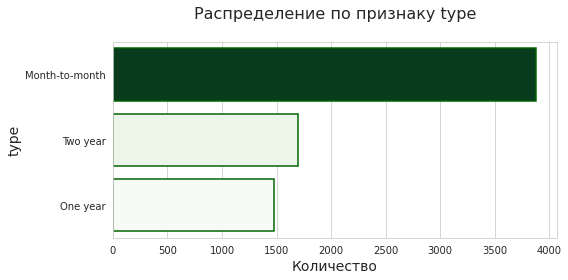

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


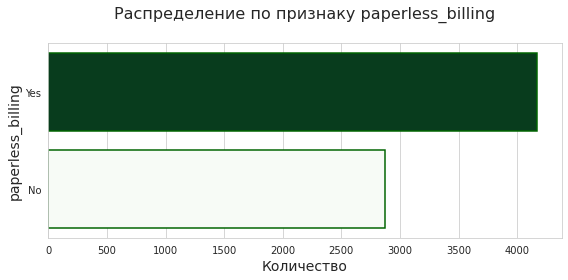

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


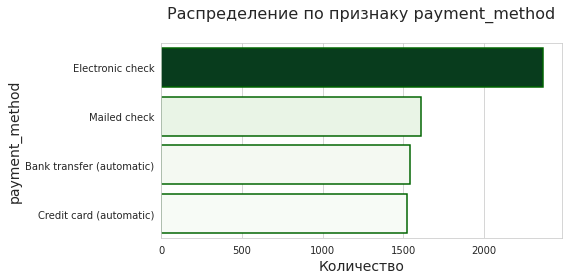

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


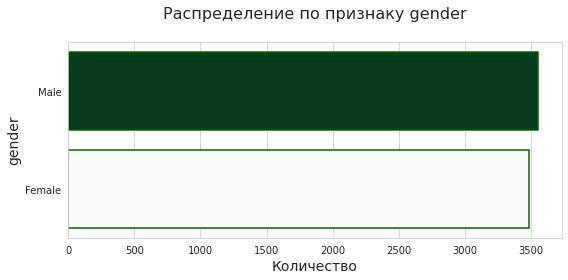

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


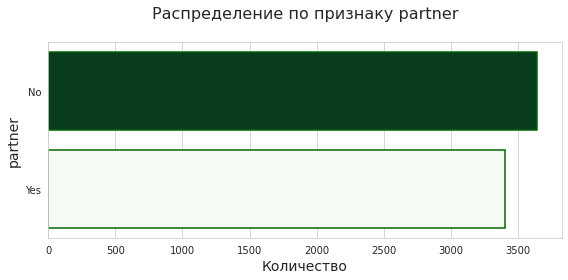

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


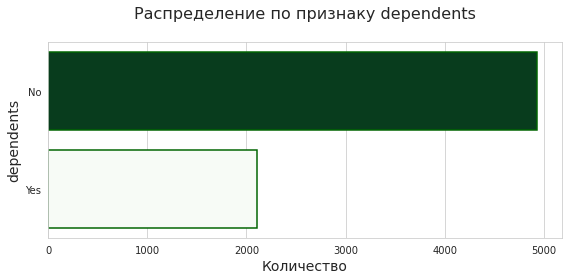

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


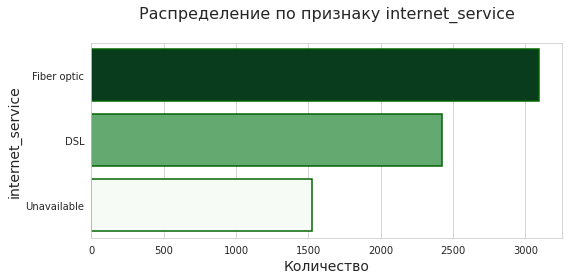

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


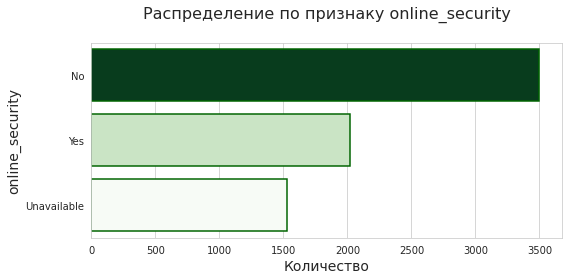

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


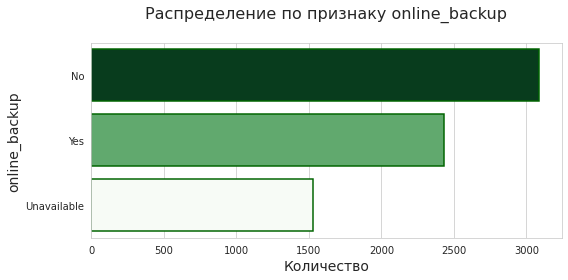

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


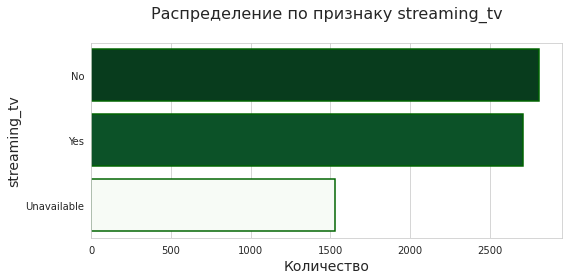

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


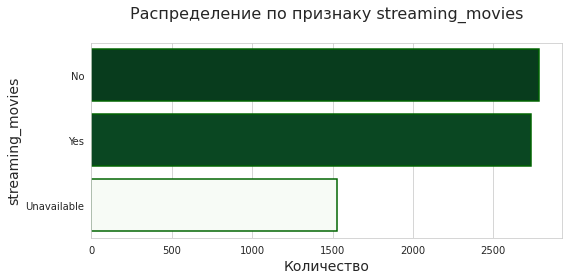

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


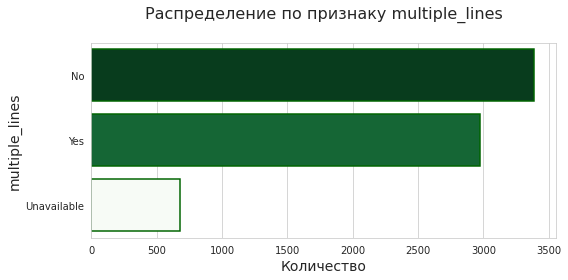

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


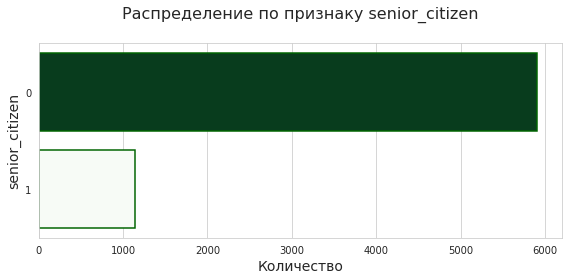

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


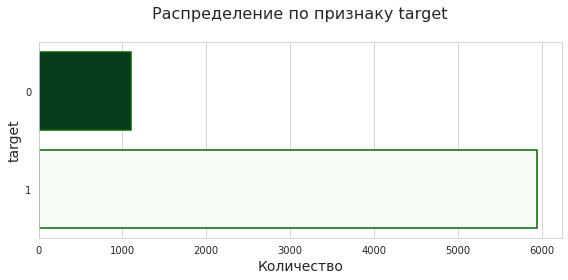

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [33]:
for i in cat_columns:
    bar_plot_data(df, i)
    print('>>--<< >>--<< ' * 8)

**обзор категориальных признаков**:
* наиболее популярный тип оплаты &mdash; month-to-month.
* большей части клиентов не нужен бумажный расчётеый лист 
* наиболее популярный тип оплаты &mdash; электронный чек
* примерно равное распределение клиентов по  полу и семейному положению 
* клиенты с детьми в меньшинстве
* Fiber optic более популярен, чем DSL
* услуги, от которых клиенты чаще отказываются: Блокировка опасных сайтов, Облачное хранилище, Антивирус, Техподдержка
* подавляющее большинство клиентов младше пенсионного возраста
* примерно половина клиентов отказывается от стримингового ТВ и от каталога фильмов
* подавляющее большинство абонентов продолжают пользоваться услугами сервиса

визуализация признаков выявила дисбаланс классов: ситуацию, когда одного типа клиентов в данных гораздо больше, чем другого типа (например, актуальных клиентов значительно больше, чем ушедших; пенсионеров значительно меньше, чем клиентов более молодого возраста).

чем это чревато. <br>
модели ML могут “учиться” предсказывать большинство и игнорировать редкий класс (например, реальных клиентов, склонных к оттоку). в итоге метрики качества будут выглядеть хорошо, но модель не сможет выявлять тех, кто действительно уходит.

как бороться: <br>
* оценивать качество обучения по метрикам, чувствительным к дисбалансу (например, AUC-ROC)
* при необхоимости применять взвешивание классов (class_weight='balanced'), чтобы модель уделяла больше внимания редкому классу;
* при необходимости применить пересэмплирование данных (увеличивать долю редкого класса).

теперь перейдём к количественным признакам.

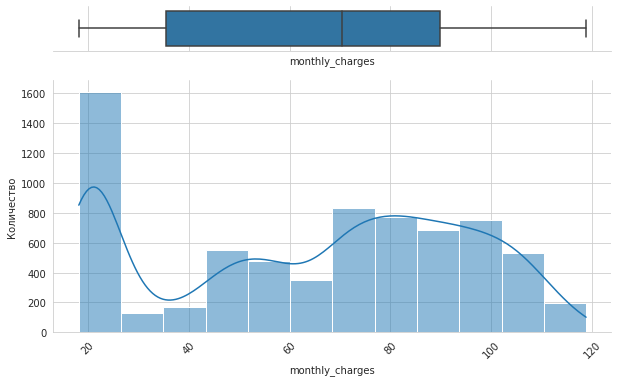

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


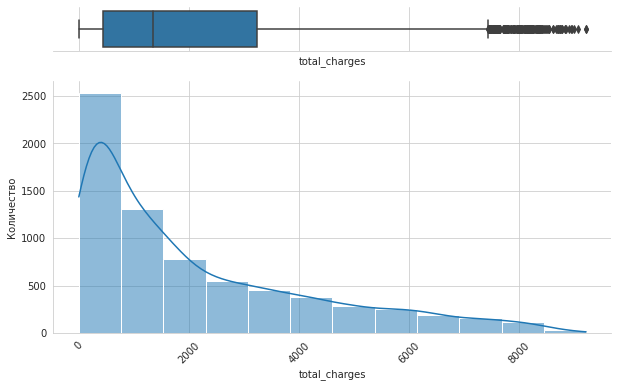

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


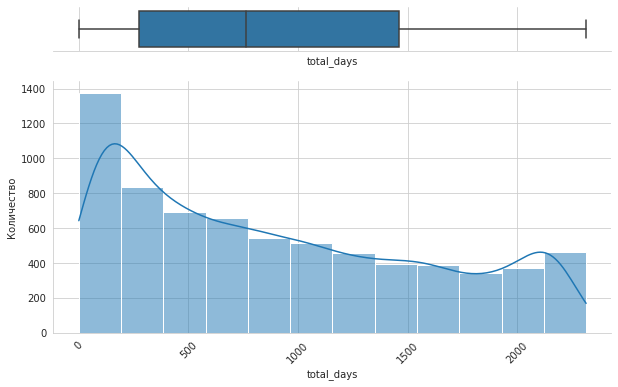

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [34]:
for i in num_columns:
    data_box_hist(df[i])
    print('>>--<< >>--<< ' * 8)

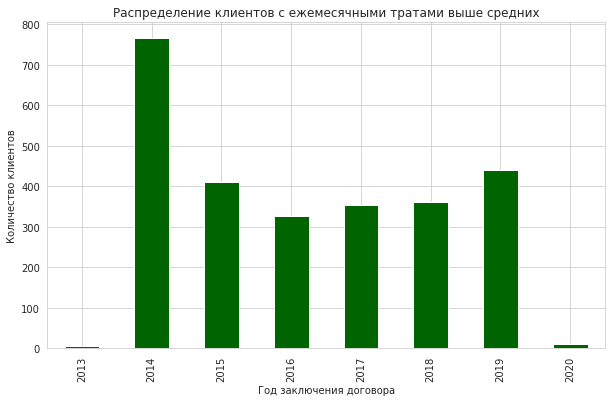

In [35]:
# посмотрим на динамику прироста новых клиентов с ежемесячными тратами выше средних:
high_spenders = df.query('monthly_charges >= 80').copy()
high_spenders['begin_year'] = high_spenders['begin_date'].dt.year

high_spenders['begin_year'].value_counts().sort_index().plot(
    kind='bar',
    color='Darkgreen',
    title='Распределение клиентов с ежемесячными тратами выше средних'
)

plt.xlabel('Год заключения договора')
plt.ylabel('Количество клиентов')
plt.show()

**обзор количественных признаков**:
* в месячных расходах (`monthly_charges`) заметен пик около 20, который соответствует минимальному значению.
* у большей части клиентов общие затраты (`total_charges`) в пределах 1500 рублей, при этом мы видим всплеск количества клиентов с месячными расходами выше средних (около 80): всплеск популярности дорогих тарифов был на старте, в 2014, однако потом наблюдается резкий спад (почти вдвое), выровнять который на данный момент не удалось.
* наличие двух пиков в распределении `total_days` отражает наличие как новых, так и постоянных клиентов, что свидетельствует о сохранении части аудитории и стабильности клиентской базы. 
* аномальных значений не наблюдается.

теперь посмотрим, как распределены признаки с точки зрения оттока.  
начнём с количесвтенных признаков.

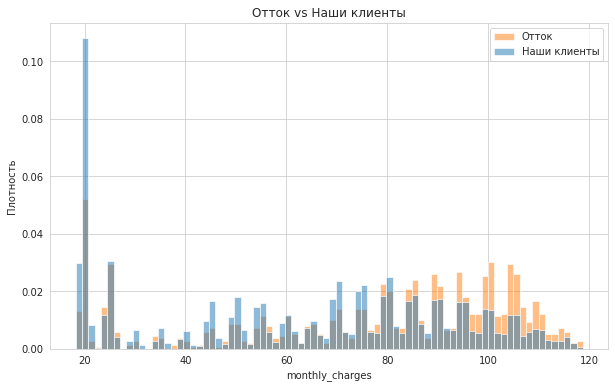

In [36]:
outflow_hist('monthly_charges', 80)

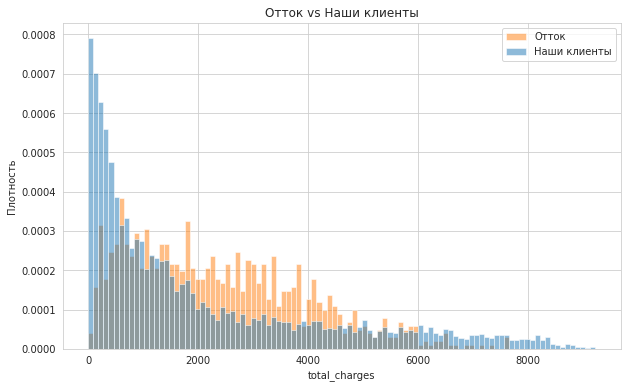

In [37]:
outflow_hist('total_charges', 100)

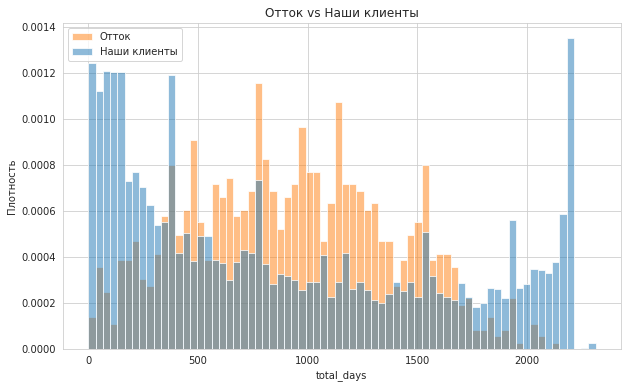

In [38]:
outflow_hist('total_days', 70)

* чаще отказываются от услуг клиенты, оформившие дорогой тариф и, что логично, имевшие высокие общие траты на оплату услуг
* при этом повышение доли оттока наблюдается у клиентов, имеющих среднюю продолжительность пользования услугами (низкий отток среди старичков и не вызывающий опасений уровень оттока среди новеньких)

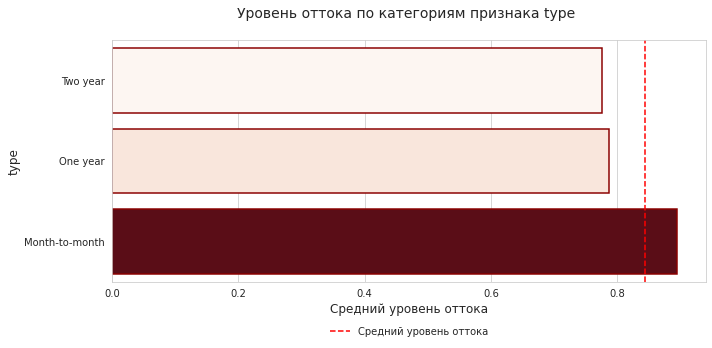

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


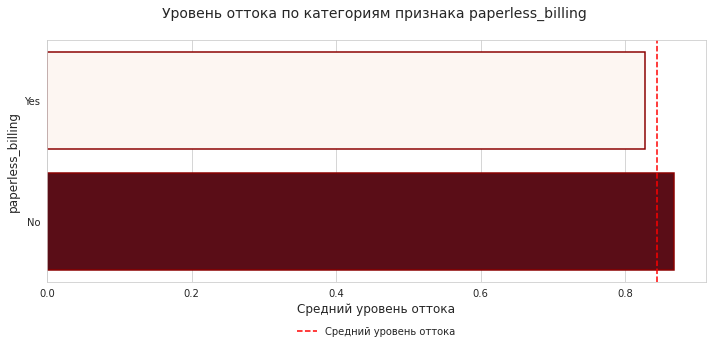

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


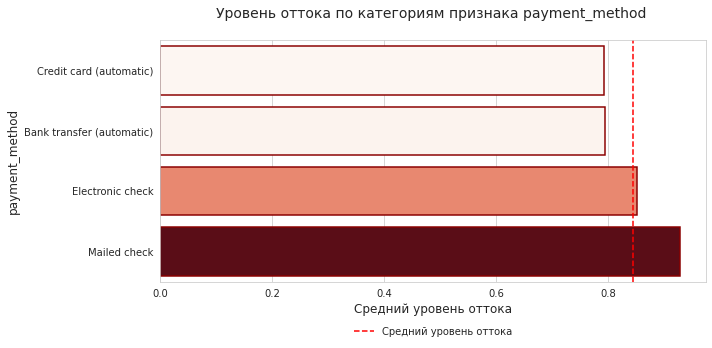

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


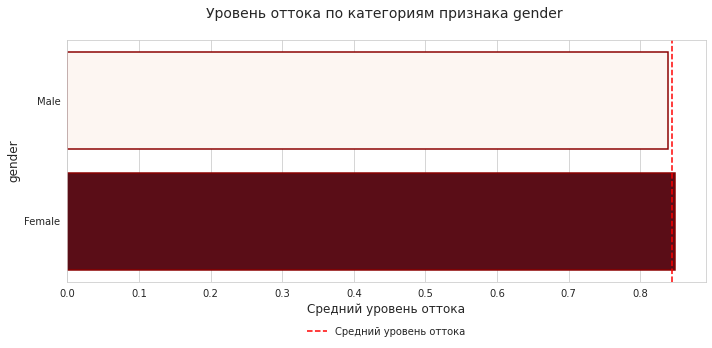

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


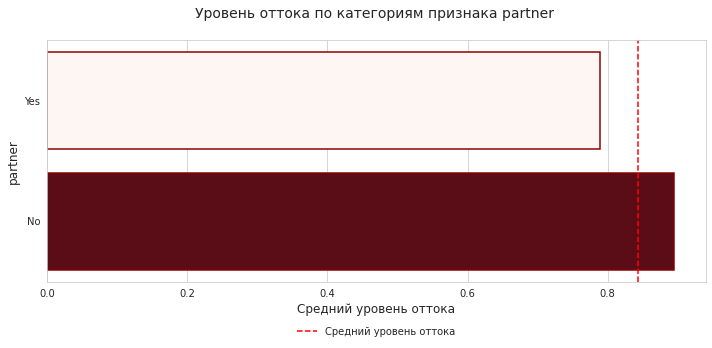

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


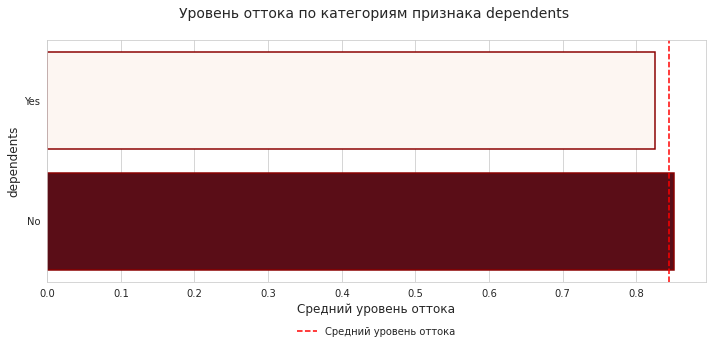

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


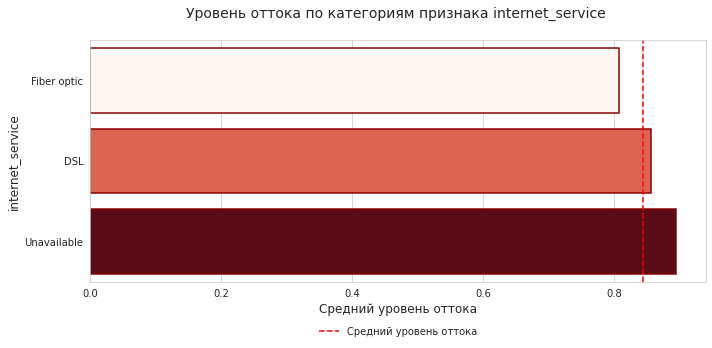

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


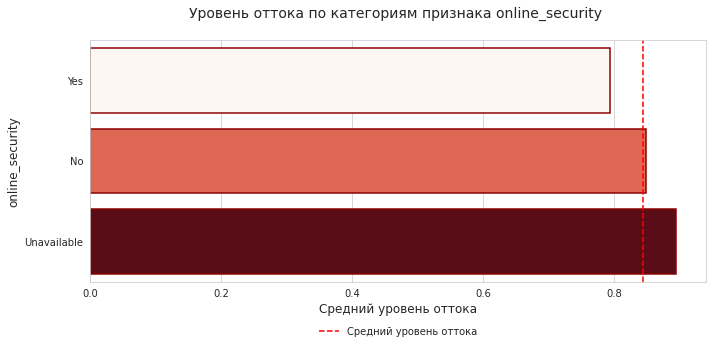

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


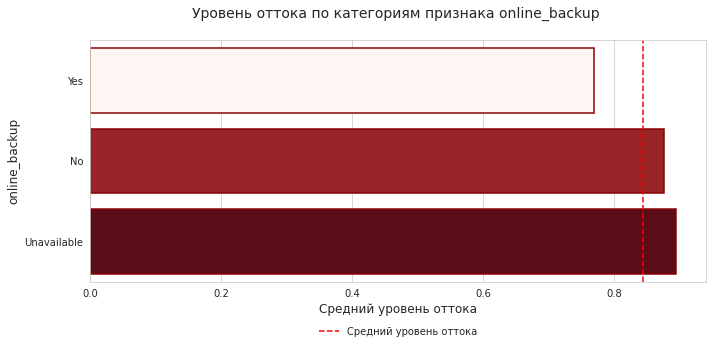

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


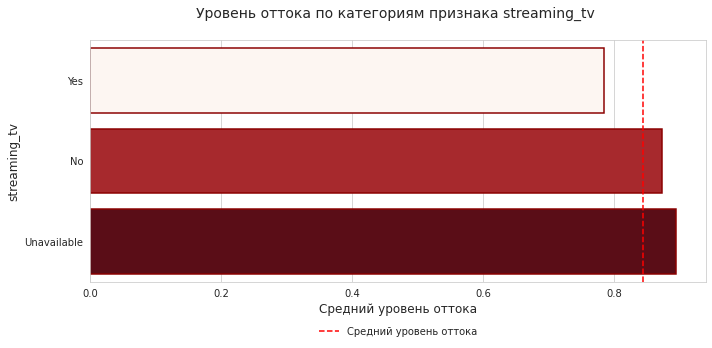

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


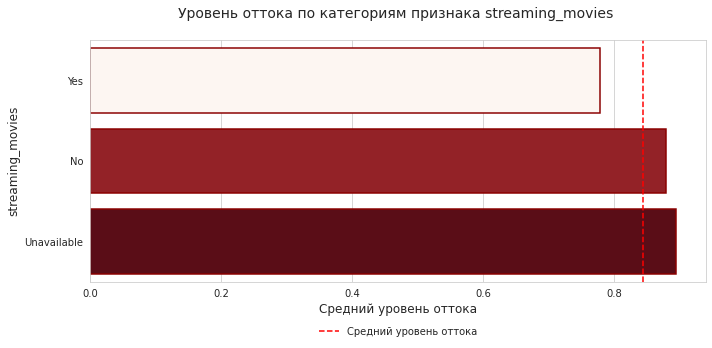

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


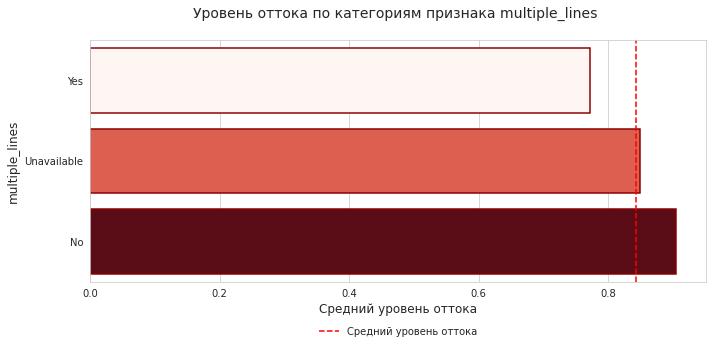

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


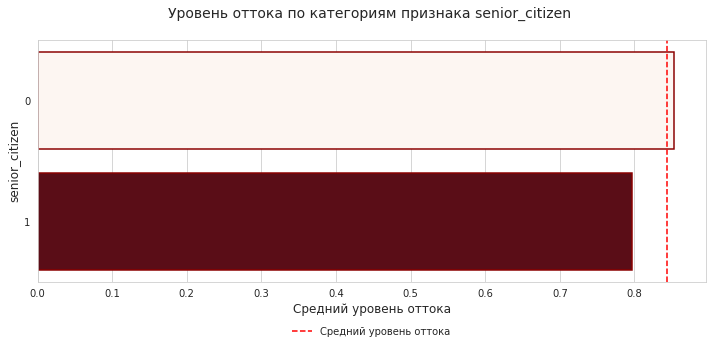

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [39]:
for i in cat_columns:
    if i == 'target':
        continue
    outflow_cat(df, i)
    print('>>--<< >>--<< ' * 8)

📈 **промежуточный вывод**:<br>
визуализация выше позволяет нам составить собтрательный портрет клиента, которого легко потерять:
* использует помесячный тип оплаты;
* предпочитает выставление счёта по почте (данный способ оплаты очевидно востребован, но, вероятно, нуждается в оптимизации);
* скорее всего, не имеет партнёра и детей;
* для пользователей интернет-услуг: не подключает дополнительные сервисы;
* для пользователей телефонии: отказался от опции подключения телефона к нескольким линиям;
* пользуется услугами компании более года;
* недоволен суммой трат на услугу.

таким образом, наш ускользающий клиент уже освоился на рынке, сравнивает предложения разных компаний и, вероятно, ищет более выгодные альтернативы.

**матрица корреляции**

перед тем как перейти непосредственно к построению и обучению моделей, посмотрим на матрицу корреляции признаков (предварительно удалив из неё столбцы, содержащие даты заключения и расторжения договоров: у нас есть признак, фиксирующий стаж клиента в днях)

In [40]:
df = df.drop(['begin_date', 'end_date'], axis=1)

In [41]:
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Unavailable
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Unavailable
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


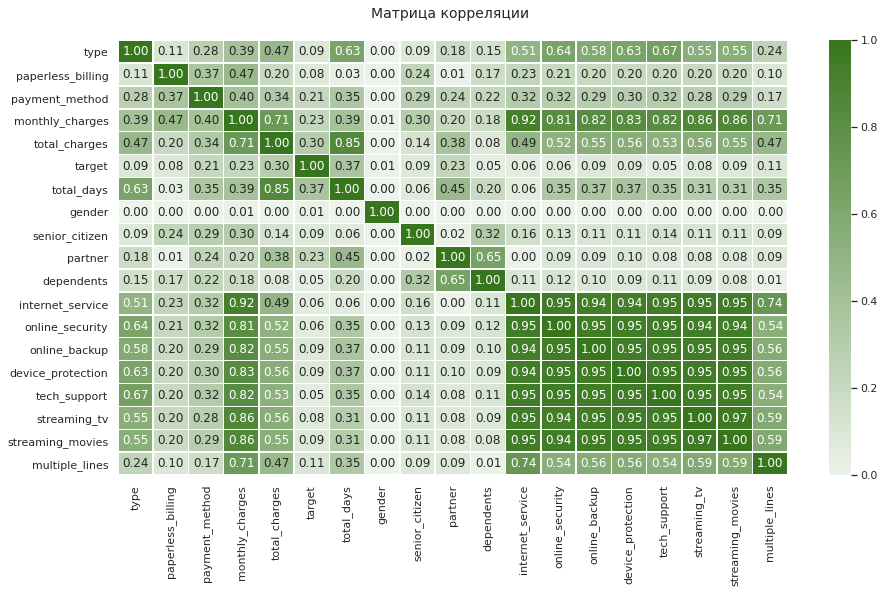

In [42]:
matrix_corr = df.drop('customer_id', axis=1).phik_matrix(interval_cols=['monthly_charges', 'total_charges','total_days'])
green_cmap = sns.light_palette("#38761d", as_cmap=True)
sns.set(rc={"figure.figsize": (15, 8)})
sns.heatmap(matrix_corr, annot=True, fmt='.2f', cmap=green_cmap, linewidths=0.5) 
plt.title('Матрица корреляции \n', fontsize=14)
plt.show()

из датасета можно удалить следующиестолбцы:
* gender &mdash; корреляция с target отсутствует;
* internet_service, online_security, device_protection, streaming_tv, streaming_movies, tech_support - корреляция слишком сильная; однако предварительно на их иснове мы создадим столбец, с информацией о количестве сервисов, подключённых у пользователя.

также мы дополнительно проведём разметку пользователей по типу договора на оказание услуг: интернет, телефония, либо двойной договор (и то, и другое).


In [43]:
# составим писок услуг
services = [
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_tv', 
    'streaming_movies', 
    'multiple_lines'
]

# создадим новый столбец 'num_services', дяя которого посчитаем количество 'Yes' для каждого клиента
df['num_services'] = df[services].apply(lambda row: sum(row == 'Yes'), axis=1)

df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,num_services
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,Female,0,...,No,DSL,No,Yes,No,No,No,No,Unavailable,1
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,2
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,2
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,Unavailable,3
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


на начальных этапах исследования мы выяснили, что списки пользователей интернета и телефонии частично пересекаются. сделаем допольнительную разметку клиентов по типу договора: только телефония, только интернет, либо двойной (и то, и другое).

In [44]:
conditions = [
    df['multiple_lines'] == 'Unavailable',     # нет телефонии
    df['internet_service'] == 'Unavailable'    # нет услуг интернета
]

choices = ['интернет', 'телефония']
df['contract_type'] = np.select(conditions, choices, default='двойной')

df[['customer_id', 'multiple_lines', 'internet_service', 'contract_type']].head()

,customer_id,multiple_lines,internet_service,contract_type
0,7590-VHVEG,Unavailable,DSL,интернет
1,5575-GNVDE,No,DSL,двойной
2,3668-QPYBK,No,DSL,двойной
3,7795-CFOCW,Unavailable,DSL,интернет
4,9237-HQITU,No,Fiber optic,двойной


теперь можно отбросить признаки, которые выше мы определили под удаление:

In [45]:
df_clean = df.drop(['internet_service', 'online_security',
                   'device_protection', 'streaming_tv',
                   'streaming_movies', 'tech_support', 
                   'gender', 'online_backup',
                   'multiple_lines'], axis=1)

In [46]:
df_clean.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,senior_citizen,partner,dependents,num_services,contract_type
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,0,Yes,No,1,интернет
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036,0,No,No,2,двойной
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,0,No,No,2,двойной
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,0,No,No,3,интернет
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,0,No,No,0,двойной


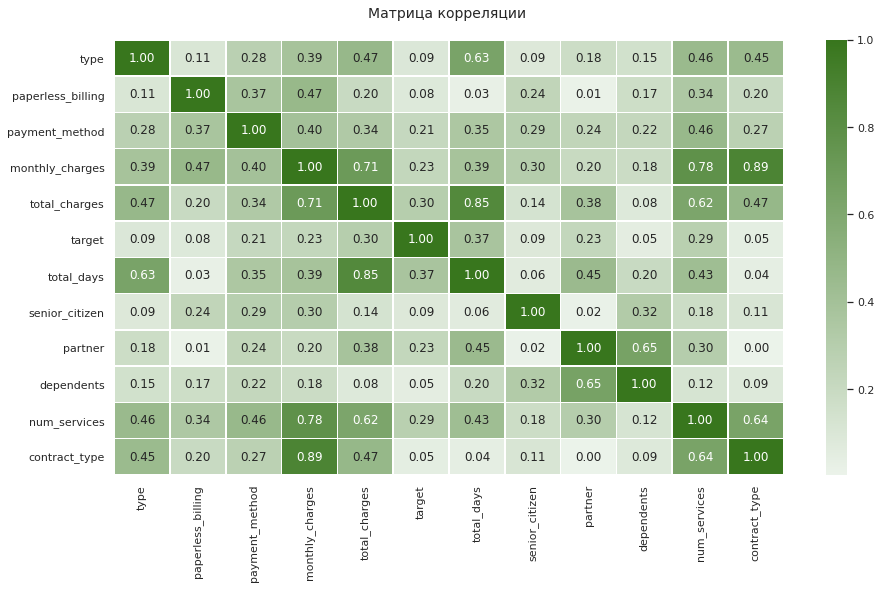

In [47]:
matrix_corr = df_clean.drop('customer_id', axis=1).phik_matrix(interval_cols=['monthly_charges', 'total_charges','num_services', 'total_days'])
green_cmap = sns.light_palette("#38761d", as_cmap=True)
sns.set(rc={"figure.figsize": (15, 8)})
sns.heatmap(matrix_corr, annot=True, fmt='.2f', cmap=green_cmap, linewidths=0.5) 
plt.title('Матрица корреляции \n', fontsize=14)
plt.show()

📈 **промежуточный вывод** <br>
после устранения неинформативных признаков и добавления новых мы видим:
* сильная зависимость наблюдается между признаками `monthly_charges`, `contract_type` и `num_services` — это логично, поскольку более длительные договоры и большее число подключённых услуг обычно ведут к более высокой ежемесячной плате.
* `total_charges` сильно коррелирует с `total_days` (0.85), что объясняется тем, что суммарные траты растут с длительностью обслуживания.
* целевой признак (`target`) не демонстрирует сильной связи ни с одним отдельным фактором, следовательно, отток клиентов зависит от совокупности признаков, а не от одного конкретного.

корреляции между остальными признаками умеренные или слабые, что говорит о хорошем уровне независимости переменных: признаки несут дополнительную информацию и не дублируют друг друга. значит, текущий набор признаков после очистки и удаления коррелирующих столбцов сбалансирован и подходит для построения модели машинного обучения без риска мультиколлинеарности.

## Модели ML

для прогнозирования оттока клиентов мы обучим три модели: LogisticRegression, RandomForest и CatBoost.  
они по-разному обрабатывают данные и выявляют закономерности:
* `Logistic Regression` — простая и интерпретируемая, показывает влияние признаков.
* `Random Forest` — хорошо работает с нелинейными зависимостями.
* `CatBoost` — современный алгоритм, оптимизированный для категориальных данных и высокой точности.

сопоставив качество метрик, мы выберем одну модель с наилучшими результатами, которая станет основой для финального прогноза оттока.

### разделение данных на обучающую и тестовую выборки

для начала конвертируем столбец `customer_id` в индексы объединённой таблицы: это позволит нам, с одной стороны, сохранить уникальность каждого наблюдения в данных; с другой стороны, мы избавляем датасет от призака, непригодного для обучения моделей.

In [48]:
df_clean = df_clean.set_index('customer_id')
df_clean.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,total_days,senior_citizen,partner,dependents,num_services,contract_type
customer_id,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,0,Yes,No,1,интернет
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,1036,0,No,No,2,двойной
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,0,No,No,2,двойной
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,0,No,No,3,интернет
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,0,No,No,0,двойной


далее на данном этапе нам предстоит:
* разделить датасет на тренировочную и тестовую выборки
* преобразовать категориальные признаки с помощь `get_dummies`, 
* масштабировать числовые признаки с помощью `StandartScaler`.

In [49]:
X = df_clean.drop(columns=['target'])
y = df_clean['target']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM_STATE
                                                   )

In [51]:
categorial = ['type', 'paperless_billing', 
              'payment_method', 'senior_citizen', 
              'partner', 'dependents', 'contract_type']

numeric = ['monthly_charges', 'total_charges', 'num_services', 'total_days']

### подготовка данных для ML модели RandomForest

In [52]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ord = encoder.fit_transform(X_train[categorial])
X_test_ord = encoder.transform(X_test[categorial])

In [53]:
X_train_ord = pd.DataFrame(X_train_ord, columns=categorial)
X_test_ord = pd.DataFrame(X_test_ord, columns=categorial)
X_test_ord

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,contract_type
0,2.0,1.0,3.0,0.0,1.0,1.0,2.0
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,2.0
3,1.0,0.0,1.0,0.0,1.0,0.0,2.0
4,2.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
1756,0.0,1.0,2.0,0.0,0.0,0.0,0.0
1757,0.0,1.0,2.0,1.0,0.0,0.0,0.0
1758,0.0,0.0,2.0,1.0,1.0,0.0,0.0
1759,0.0,1.0,0.0,0.0,0.0,0.0,0.0


масштабируем количественные признаки с помощью StandardScaler

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric])
X_test_scaled = scaler.transform(X_test[numeric])

In [55]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric)

In [56]:
X_train_forest = pd.concat((X_train_ord, X_train_scaled), axis=1)
X_test_forest = pd.concat((X_test_ord, X_test_scaled), axis=1)

In [57]:
X_train_forest.head()

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,contract_type,monthly_charges,total_charges,num_services,total_days
0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.881288,0.250592,-0.231226,-0.025163
1,1.0,0.0,3.0,0.0,0.0,0.0,2.0,-1.360301,-0.802546,-0.719369,-0.514455
2,2.0,0.0,1.0,0.0,0.0,0.0,2.0,-1.498117,-0.707757,-1.207512,0.111077
3,2.0,0.0,3.0,0.0,1.0,1.0,2.0,-1.524684,-0.869287,-1.207512,-0.693178
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.329605,-0.657420,1.233204,-1.005211


### подготовка данных для ML моделей LogisticRegression и CatBoost

In [58]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore',  sparse_output=False)

In [59]:
X_train_ohe = encoder.fit_transform(X_train[categorial])
X_test_ohe = encoder.transform(X_test[categorial])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['type_One year', 'type_Two year', 'paperless_billing_Yes',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'senior_citizen_1', 'partner_Yes', 'dependents_Yes',
       'contract_type_интернет', 'contract_type_телефония'], dtype=object)

In [60]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [61]:
X_train_lr = pd.concat((X_train_ohe, X_train_scaled), axis=1)
X_test_lr = pd.concat((X_test_ohe, X_test_scaled), axis=1)

In [62]:
X_train_lr.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_1,partner_Yes,dependents_Yes,contract_type_интернет,contract_type_телефония,monthly_charges,total_charges,num_services,total_days
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.881288,0.250592,-0.231226,-0.025163
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.360301,-0.802546,-0.719369,-0.514455
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.498117,-0.707757,-1.207512,0.111077
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,-1.524684,-0.869287,-1.207512,-0.693178
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.329605,-0.657420,1.233204,-1.005211


In [63]:
X_train.shape[0] == y_train.shape[0]

True

In [64]:
X_train_forest.shape[0] == y_train.shape[0]

True

In [65]:
X_train_lr.shape[0] == y_train.shape[0]

True

в рамках данного этапа: <br>
✔️ назначили признак `customer_id` в качестве индекса <br>
✔️ разбили объединённый датасет на тренировочную и тестовую выборки <br>
✔️ произвели кодирование признаков для обучения моделей машинного обучения. <br>

теперь можно приступать к обучению моделей.

### обучение моделей

для каждой модели будем использовать два набора гиперпараметров: базовый и расширенный, в итоге выберем ту, которая покажет наилучшие результаты, адекватные времени обучения.

для оценки качества обучения моделей мы будем использовать метрику `ROC-AUC`: она показывает, насколько хорошо модель различает клиентов, склонных к оттоку, и тех, кто остаётся.  

если метрика качества ROC-AUC ≥ 0.85, значит, модель достаточно точно распознаёт риск ухода клиента.

**<u>RandomForest I</u>**

In [66]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid = {
  'n_estimators': [50, 100, 200, 500],
  'max_depth': [5, 10, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}

randomized_search = RandomizedSearchCV(
    model,
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE # добавила random_state
)

In [67]:
start_time = time.time()
randomized_search.fit(X_train_forest, y_train)
end_time = time.time()

training_time = end_time - start_time

print("Лучшая модель и её параметры:")
for k, v in randomized_search.best_params_.items():
    print(f"  {k}: {v}")

print(f"\n⏱ Время на обучение модели: {training_time:.2f} секунд"
      f"\nROC-AUC лучшей модели на кросс-валидации: {randomized_search.best_score_:.3f}" # скорректирован вывод результата
     )

Лучшая модель и её параметры:
  n_estimators: 500
  min_samples_split: 2
  min_samples_leaf: 1
  max_depth: 10

⏱ Время на обучение модели: 61.98 секунд
ROC-AUC лучшей модели на кросс-валидации: 0.832


**<u>RandomForest II</u>**

In [68]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [200, 500, 700, 1000],
    'max_depth': [20, 25, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

randomized_search = RandomizedSearchCV(
    model,
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE # добавила random_state
)

start_time = time.time()
randomized_search.fit(X_train_forest, y_train)
end_time = time.time()

training_time = end_time - start_time

print("Лучшая модель и её параметры:")
for k, v in randomized_search.best_params_.items():
    print(f"  {k}: {v}")

print(f"\n⏱ Время на обучение модели: {training_time:.2f} секунд"
      f"\nROC-AUC лучшей модели на кросс-валидации: {randomized_search.best_score_:.3f}" # скорректирован вывод результата
     )

Лучшая модель и её параметры:
  n_estimators: 700
  min_samples_split: 10
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 20

⏱ Время на обучение модели: 195.86 секунд
ROC-AUC лучшей модели на кросс-валидации: 0.828


**<u>LogisticRegression I</u>**

In [69]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

model = LogisticRegression(
    solver='lbfgs', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='roc_auc')

start_time = time.time()
grid_search.fit(X_train_lr, y_train)
end_time = time.time()

training_time = end_time - start_time

#cv_scores_lr1 = cross_val_score( -- убираем повторную кросс-валидацию
#    grid_search.best_estimator_,
#    X_train_lr,
#    y_train,
#    cv=5,
#    scoring='roc_auc'
# )

print("Лучшая модель и её параметры:")
for k, v in grid_search.best_params_.items():
    print(f"  {k}: {v}")
    
print(f"\n⏱ Время на обучение модели: {training_time:.2f} секунд"
      f"\nROC-AUC лучшей модели на кросс-валидации: {grid_search.best_score_:.3f}" # скорректирован вывод результата
     )

Лучшая модель и её параметры:
  C: 100

⏱ Время на обучение модели: 13.33 секунд
ROC-AUC лучшей модели на кросс-валидации: 0.756


**<u>LogisticRegression II</u>**

In [70]:
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 500, 1000]
}

model = LogisticRegression(
    solver='lbfgs',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

start_time = time.time()
grid_search.fit(X_train_lr, y_train)
end_time = time.time()

training_time = end_time - start_time

#cv_scores_lr2 = cross_val_score( -- убираем повторную кросс-валидацию
#    grid_search.best_estimator_,
#    X_train_lr,
#    y_train,
#    cv=5,
#    scoring='roc_auc'
#)

print("Лучшая модель и её параметры:")
for k, v in grid_search.best_params_.items():
    print(f"  {k}: {v}")

print(f"\n⏱ Время на обучение модели: {training_time:.2f} секунд"
      f"\nROC-AUC лучшей модели на кросс-валидации: {grid_search.best_score_:.3f}" # скорректирован вывод результата
     )

Лучшая модель и её параметры:
  C: 100
  class_weight: balanced
  max_iter: 100
  penalty: l2

⏱ Время на обучение модели: 85.41 секунд
ROC-AUC лучшей модели на кросс-валидации: 0.756


**<u>CatBoost I</u>**

In [71]:
param_grid = {
    'learning_rate': [1, 0.5],
    'iterations': [50, 150],
    'l2_leaf_reg': [2, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

cat_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='roc_auc')

start_time = time.time()
cat_search.fit(X_train_lr, y_train)
end_time = time.time()

training_time = end_time - start_time

#cv_scores_cat1 = cross_val_score( -- убираем повторную кросс-валидацию
#    cat_search.best_estimator_,
#    X_train_lr,
#    y_train,
#    cv=5,
#    scoring='roc_auc'
#)

print("Лучшая модель и её параметры:")
for k, v in cat_search.best_params_.items():
    print(f"  {k}: {v}")
    
print(f"\n⏱ Время на обучение модели: {training_time:.2f} секунд"
      f"\nROC-AUC лучшей модели на кросс-валидации: {cat_search.best_score_:.3f}" # скорректирован вывод результата
     )

Лучшая модель и её параметры:
  iterations: 150
  l2_leaf_reg: 2
  learning_rate: 0.5

⏱ Время на обучение модели: 38.30 секунд
ROC-AUC лучшей модели на кросс-валидации: 0.892


**<u>CatBoost II</u>**

In [72]:
param_grid = {
    'learning_rate': [0.05, 0.1],
    'iterations': [300, 500, 700],
    'depth': [4, 6],
    'l2_leaf_reg': [3, 5, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

cat_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='roc_auc')

start_time = time.time()
cat_search.fit(X_train_lr, y_train)
end_time = time.time()

training_time = end_time - start_time

#cv_scores_cat2 = cross_val_score( -- убираем повторную кросс-валидацию
#    cat_search.best_estimator_,
#    X_train_lr,
#    y_train,
#    cv=5,
#    scoring='roc_auc'
# )

print("Лучшая модель и её параметры:")
for k, v in cat_search.best_params_.items():
    print(f"  {k}: {v}")

print(f"\n⏱ Время на обучение модели: {training_time:.2f} секунд"
      f"\nROC-AUC лучшей модели на кросс-валидации: {cat_search.best_score_:.3f}" # скорректирован вывод результата
     )

Лучшая модель и её параметры:
  depth: 4
  iterations: 700
  l2_leaf_reg: 3
  learning_rate: 0.1

⏱ Время на обучение модели: 324.16 секунд
ROC-AUC лучшей модели на кросс-валидации: 0.921


📈 **промежуточный вывод**: <br>
в первых двух случаях более "тяжёлый" набор параметров не дал прироста в метрике качества, что позволяет говорить о том, что модель максимально обучена не предложенном наборе признаков.

в случае с CatBoost мы наблюдаем прирост метрики с 0.892 до 0.921, однако время обучения модели увеличилось в 8 раз. предлагаю остановить выброр на модели CatBoost I:

* параметры модели `iterations: 150 | l2_leaf_reg: 2 | learning_rate: 0.5`
* время на обучение: 38.30 секунд
* метрика качества ROC-AUC: 0.892

## Тестирование модели и анализ результатов
### тестирование и проверка на адекватность

на этапе тестирования мы воспользуемся той же метрикой качества, которая была на стадии обучения: `ROC-AUC`.<br>
дополнительно для более наглядной интерпретации результатов мы применим метрику `accuracy` (точность), которая покажет долю верно предсказанных случаев. эта метрика проще для восприятия и помогает быстро оценить, насколько часто модель угадывает поведение клиентов правильно.

In [73]:
probabilities = cat_search.predict_proba(X_test_lr)[:,1]
print('Площадь ROC-кривой:', round(roc_auc_score(y_test, probabilities),2))

Площадь ROC-кривой: 0.93


посчитаем также `accuracy` для более лёгкой интерпретируемости модели.

In [74]:
predicted_classes = np.where(probabilities >= 0.5, 1, 0)
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.929


значение метрики `accuracy` (точность модели) 0.929 указывает на то, что модель имеет хорошую производительность, так как более 90% предсказаний верны.

теперь проверим лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели `DummyClassifier`. это позволит нам убедиться, что наш алгоритм действительно делает предсказания, а не просто случайно угадывает ответы.

DummyClassifier — это модель, которая не учится на данных, а вместо этого делает предсказания по простому принципу (всегда выбирает самый частый класс или случайно угадывает 0 и 1). если метрика качества CatBoost показывает метрику существенно выше, значит, обученная модель действительно извлекает закономерности из данных.

In [75]:
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

print('Площадь ROC-кривой:', roc_auc_score(y_test, y_pred))

Площадь ROC-кривой: 0.5


модель `CatBoost` прошла проверку на адекватность: она хорошо различает классы независимо от их распределения.

### вычисление важности признаков

,importances
total_days,59.634012
total_charges,10.508210
monthly_charges,10.207052
num_services,5.376265
type_Two year,3.662175
partner_Yes,2.490467
payment_method_Mailed check,1.689495
type_One year,1.537508
dependents_Yes,1.494232
payment_method_Credit card (automatic),0.891210


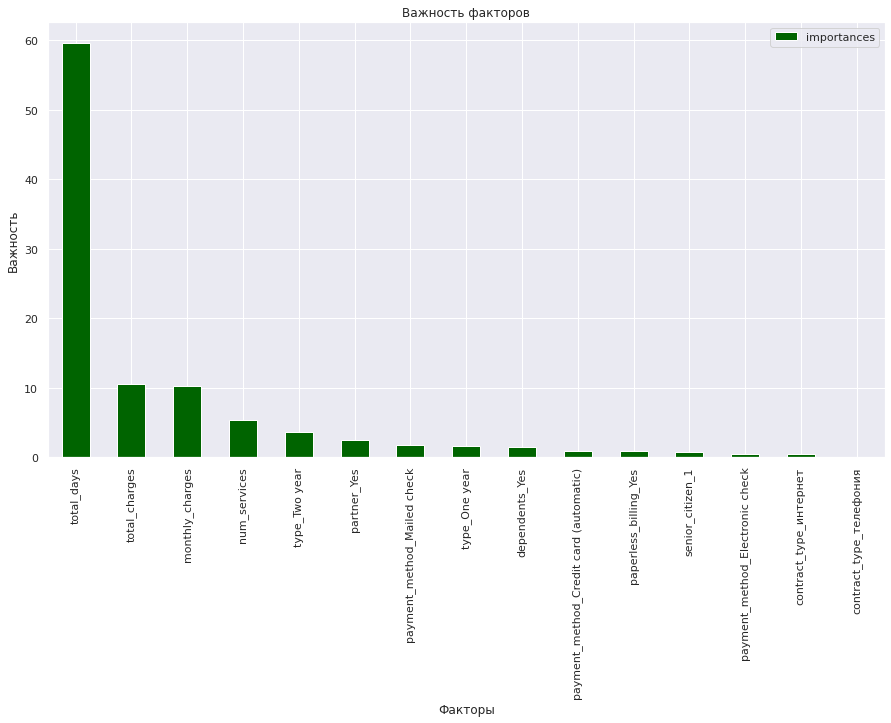

In [76]:
importance = pd.DataFrame(cat_search.best_estimator_.feature_importances_, 
                          index = X_test_lr.columns, columns=['importances'])
importance = importance.sort_values(by='importances', ascending=False)
display(importance)

importance.plot(kind='bar', color='Darkgreen', title='Важность факторов')
plt.xlabel('Факторы') 
plt.ylabel('Важность')
plt.show()

наиболее важным фактором является `total_days`, следом за ним идут значимые факторы `monthly_charges`, `total_charges` и `num_services` (обобщённый признак, которым мы заменили набор дополнительных услуг для интернета и телефонии)

### матрица ошибок

на следующем этапе мы обратимся к матрице ошибок (confusion matrix), которая показывает, насколько точно модель отличает оставшихся клиентов от ушедших. она же позволит нам оценить не только общую точность, но и увидеть, какие именно ошибки делает модель (например, сколько клиентов она ошибочно посчитала ушедшими или, наоборот, пропустила среди реально ушедших). <br>

на данном шаге мы посмотрим на поведение модели и оценим бизнес-риски: где важнее уменьшить ложные тревоги, а где — не пропустить клиентов, которые действительно могут уйти.

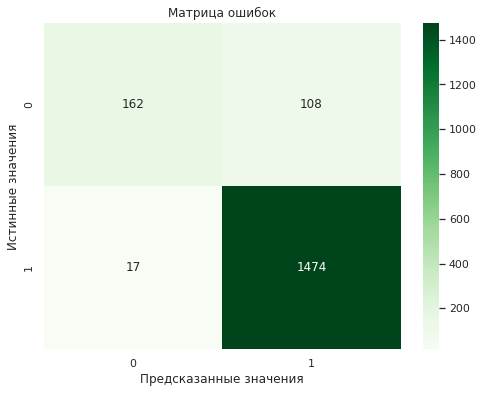

In [77]:
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", 
      xticklabels=np.unique(y_test),
      yticklabels=np.unique(y_test))
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.title("Матрица ошибок")

plt.show()

расшифровка графика:

* TruePositive (верно положительные): 1474 актуальных пользователя были предасказаны верно.
* TrueNegative (верно отрицательные): 162 ушедших пользователей были предсказаны верно.
* FalsePositive (Ложно положительные): 108 ушедших пользователей были ложно предсказаны как актуальные.
* FalaeNegative (Ложно отрицательные): 17 актуальных пользователей были ложно предсказаны как ушедшие.

то есть ошибки распределены умеренно:
* модель редко ошибается, принимая активных клиентов за ушедших (17 случаев);
* при этом основная часть ошибок — это ложно положительные (108 клиентов, которых модель ошибочно посчитала остающимися).

в целом можно сказать, что модель надёжно выявляет клиентов с риском оттока, что делает её пригодной для дальнейшего использования в аналитике и маркетинговых кампаниях удержания.

## Общий вывод и рекомендации заказчику

в ходе проекта была проведена комплексная работа по анализу и моделированию клиентского оттока:
* проведена очистка данных: устранены дубликаты и пропуски.
* определён целевой признак `target` на основе даты расторжения договора (`end_date`), что позволило разделить клиентов на актуальных и ушедших.
* проведён исследовательский анализ данных (EDA):
    * выявлен дисбаланс классов — доля ушедших клиентов заметно меньше;
    * сформирован портрет клиента, склонного к оттоку:
        * использует помесячный тип оплаты;
        * предпочитает счёт по почте (возможная точка оптимизации процесса оплаты);
        * чаще не имеет партнёра и детей;
        * не подключает дополнительные услуги (для интернет-пользователей);
        * отказывается от опции нескольких линий (для пользователей телефонии);
        * пользуется услугами компании более года;
        * недоволен суммой ежемесячных трат.
* подготовлены данные для обучения: удалены неинформативные признаки, добавлены новые признаки (`contract_type`, `num_services`)
* проведено обучение трёх моделей:
    * RandomForestClassifier
    * LogisticRegression
    * CatBoostClassifier
    
для каждой модели были протестированы два набора гиперпараметров: базовый и расширенный. существенный прирост метрики показал только CatBoost, улучшив AUC-ROC с 0.892 до 0.921, хотя время обучения выросло в 8 раз.

для итогового тестирования выбрана CatBoost I с параметрами:<br>
`iterations: 150 | l2_leaf_reg: 2 | learning_rate: 0.5`

**<u>результаты тестирования</u>**: <br>
* AUC-ROC = 0.93 — модель очень хорошо различает клиентов, склонных к оттоку, и лояльных.
* Accuracy = 0.929 — около 93% клиентов классифицируются верно.

**наиболее важные признаки**: total_days, monthly_charges, total_charges, num_services.

**анализ матрицы ошибок** показал, что модель надёжно выявляет клиентов с риском оттока, а число ошибок классификации незначительно.

🚀 **<u>Рекомендации для бизнеса</u>**: 🚀

1. сфокусировать усилия удержания на клиентах с высоким ежемесячным платежом и длительным сроком обслуживания — именно они чаще уходят.
2. оптимизировать процесс оплаты по почте и рассмотреть внедрение удобных электронных способов.
3. продвигать дополнительные услуги (особенно среди интернет-пользователей), т.к. это повышает вовлечённость и снижает вероятность оттока.
4. разработать персональные предложения для клиентов, пользующихся услугами более года, т.к. удержание этой категории наиболее эффективно.
5. внедрить систему раннего предупреждения на основе обученной модели: автоматически выделять клиентов с высоким риском оттока и направлять им специальные предложения.